Objective: Predict housing prices using a Stacking Ensemble approach.
Methodology:
1. Outlier Removal: Filtering extreme prices and areas to stabilize the model.
2. Feature Engineering: creating interaction terms and one-hot encoding.
3. Polynomial Features: Generating complex relationships between features.
4. Feature Selection: Using SelectKBest to keep only the top 120 features.
5. Modeling: Combining Ridge Regression and Gradient Boosting via a StackingRegressor.
6. Target Scaling: Using StandardScaler on the raw price target to handle real-world currency values effectively.

---
### 1. Import and setup

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import kagglehub
import warnings

from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor, StackingRegressor
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.preprocessing import RobustScaler, PolynomialFeatures, StandardScaler
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.compose import TransformedTargetRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Configuration
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
%matplotlib inline

print("Libraries Loaded Successfully.")

Libraries Loaded Successfully.


### 2. Load data

In [2]:
# Download latest version via KaggleHub
path = kagglehub.dataset_download("harishkumardatalab/housing-price-prediction")
print(f"Dataset downloaded to: {path}")

ds_raw = pd.read_csv(path + "/Housing.csv", header=0)
ds = ds_raw.copy()

# Preview
print(f"Original Dataset Shape: {ds.shape}")
ds.head()

Using Colab cache for faster access to the 'housing-price-prediction' dataset.
Dataset downloaded to: /kaggle/input/housing-price-prediction
Original Dataset Shape: (545, 13)


,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
0,13300000,7420,4,2,3,yes,no,no,no,yes,2,yes,furnished
1,12250000,8960,4,4,4,yes,no,no,no,yes,3,no,furnished
2,12250000,9960,3,2,2,yes,no,yes,no,no,2,yes,semi-furnished
3,12215000,7500,4,2,2,yes,no,yes,no,yes,3,yes,furnished
4,11410000,7420,4,1,2,yes,yes,yes,no,yes,2,no,furnished


### 3. Outlier removal

The optimal outliers to remove seem to be the houses with to much area and price. The if taken too much or too litle the model seem to affect badly the predictions. Because the amout of data is not to big, we either take to much from training or give confusing data.

In [3]:
# 1. Filter by Area
ds = ds[ds['area'] < 14000]

# 2. Filter Top 20% Expensive Prices
max_price = ds['price'].max()
cutoff_limit = max_price * 0.80

rows_before = len(ds)
ds = ds[ds['price'] <= cutoff_limit]

print(f"Dataset cleaned. Removed {rows_before - len(ds)} high-end outliers.")
print(f"New Max Price in dataset: ${ds['price'].max():,.0f}")
print(f"Remaining Samples: {len(ds)}")

Dataset cleaned. Removed 6 high-end outliers.
New Max Price in dataset: $10,150,000
Remaining Samples: 537


### 4. Feature engineering and encodng

Here we convert binary colums from "yes/no" to ones and zeros.
As for the ecoding we apply one-hot to categorical tables as well as combining features that are complimentig each other logicaly. Some combinations affect poorly while otersenhance th accuracy.
Besides this, we apply `log` to area in order to straighten the price/area ratio created by the diminishin returns.

In [4]:
# --- Binary Mapping ---
binary_columns = ["mainroad", "guestroom", "basement", "hotwaterheating", "airconditioning", "prefarea"]
for col in binary_columns:
    ds[col] = ds[col].map({"yes": 1, "no": 0})

# --- Manual Feature Creation ---
# Interaction terms based on domain logic
ds['location'] =  ds['prefarea'] * ds['mainroad']
ds['rooms_floors'] = ds['bedrooms'] * ds['stories']
ds['area_pref'] = ds['area'] * ds['prefarea']
ds['bed_area'] = ds['bedrooms'] * ds['area']

# Quality Score (Sum of amenities)
ds['quality_score'] = (ds['mainroad'] + ds['guestroom'] + ds['basement'] +
                       ds['hotwaterheating'] + ds['airconditioning'] + ds['prefarea'])

# --- One-Hot Encoding ---
# Convert categorical/ordinal columns to independent binary features
ds = pd.get_dummies(ds, columns=['furnishingstatus', 'stories', 'parking'], prefix=['furnish', 'story', 'park'], drop_first=True)

# Ensure new columns are integers (0/1)
new_cols = [c for c in ds.columns if 'furnish_' in c or 'story_' in c or 'park_' in c]
ds[new_cols] = ds[new_cols].astype(int)

# --- Feature Transformations ---
# We use log_area as an input feature because area is physically skewed
ds['log_area'] = np.log1p(ds['area'])

print("Feature Engineering Complete.")

Feature Engineering Complete.


### 5. Preprcessing pipeline

Preparin for training. Removing the base are column, as well as applying polinomila expantion. It looks a bit weirdconsidering that we have feature multiplication earlier. It enhances the results for ridge and gradient boosting, but for a "hand made" linear regression it crates a overfiting andbreakes the model. Here it adds a bitto the accuracy and makes the errors a bit smaller. And for the case that the number of fetures becomestooo larg we select only the most significant columns.

In [5]:
# Prepare Data
# We drop 'price' (Target) and 'area' (Replaced by log_area and interactions)
X = ds.drop(columns=['price', 'area'])
Y = ds['price']  # RAW DOLLARS

# --- Polynomial Expansion ---
# Create degree-2 interactions (e.g., A*B, A^2)
poly = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly.fit_transform(X)

# Convert back to DataFrame
X_poly = pd.DataFrame(X_poly, columns=poly.get_feature_names_out(X.columns))
# Remove duplicate columns generated by PolyFeatures
X_poly = X_poly.loc[:, ~X_poly.columns.duplicated()]

# --- Split ---
X_train, X_test, Y_train, Y_test = train_test_split(X_poly, Y, test_size=0.2, random_state=42)

# --- Scale ---
# RobustScaler is good for inputs that might still have some variance
scaler_x = RobustScaler()
X_train_scaled = pd.DataFrame(scaler_x.fit_transform(X_train), columns=X_train.columns)
X_test_scaled = pd.DataFrame(scaler_x.transform(X_test), columns=X_test.columns)

# --- Feature Selection ---
# Select the top 120 features most correlated with the target
selector = SelectKBest(score_func=f_regression, k=120)
selector.fit(X_train_scaled, Y_train)

cols_idx = selector.get_support(indices=True)
selected_cols = X_train_scaled.columns[cols_idx]

X_train_sel = X_train_scaled[selected_cols]
X_test_sel = X_test_scaled[selected_cols]

print(f"Total features generated: {X_poly.shape[1]}")
print(f"Features selected for training: {X_train_sel.shape[1]}")

Total features generated: 252
Features selected for training: 120


### 6. Model definition

With multiple attempts and failures, THe bes overall solution appeard to be a combination of ridgeand gradient boosting.

In [6]:
# 1. Base Models
ridge = Ridge(alpha=10)
gbr = GradientBoostingRegressor(
    n_estimators=1000,
    learning_rate=0.01,
    max_depth=3,
    subsample=0.7,
    max_features='sqrt',
    random_state=42
)

# 2. Stacking Ensemble
stack = StackingRegressor(
    estimators=[('ridge', ridge), ('gbr', gbr)],
    final_estimator=LinearRegression(),
    cv=5,
    n_jobs=-1
)

# 3. Target Transformer (Crucial for Real Values)
# Scales Price to Mean=0, Std=1 for training, converts back to Dollars for output
model = TransformedTargetRegressor(
    regressor=stack,
    transformer=StandardScaler()
)

print("Training Stacking Model on Real Dollar Values...")
model.fit(X_train_sel, Y_train)
print("Training Complete.")

Training Stacking Model on Real Dollar Values...
Training Complete.


### 7. Evaluation and visualization


 FINAL RESULTS (Raw Values)
R2 Score:  0.7197
MAE:       $749,955.73
RMSE:      $1,040,389.71
----------------------------------------


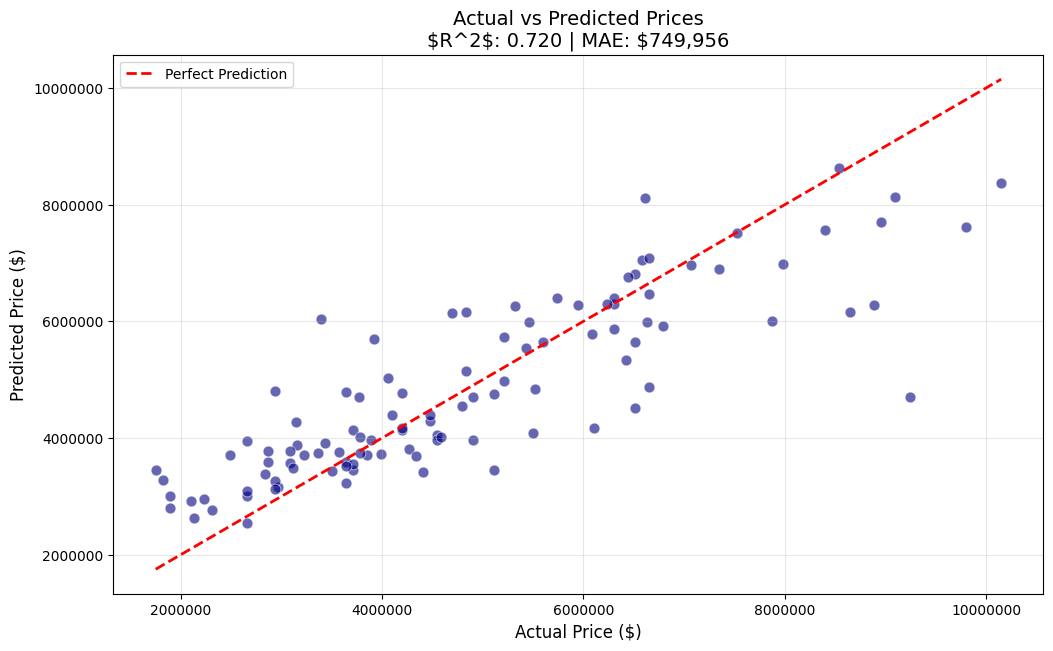

In [7]:
# Predict
y_pred = model.predict(X_test_sel)

# Metrics
mae = mean_absolute_error(Y_test, y_pred)
rmse = np.sqrt(mean_squared_error(Y_test, y_pred))
r2 = r2_score(Y_test, y_pred)

print("\n" + "="*40)
print(f" FINAL RESULTS (Raw Values)")
print("="*40)
print(f"R2 Score:  {r2:.4f}")
print(f"MAE:       ${mae:,.2f}")
print(f"RMSE:      ${rmse:,.2f}")
print("-" * 40)

# Visualization
plt.figure(figsize=(12, 7))
sns.scatterplot(x=Y_test, y=y_pred, alpha=0.6, color='navy', s=60)

# Perfect prediction line
min_val = min(Y_test.min(), y_pred.min())
max_val = max(Y_test.max(), y_pred.max())
plt.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label='Perfect Prediction')

plt.title(f'Actual vs Predicted Prices\n$R^2$: {r2:.3f} | MAE: ${mae:,.0f}', fontsize=14)
plt.xlabel('Actual Price ($)', fontsize=12)
plt.ylabel('Predicted Price ($)', fontsize=12)
plt.legend()
plt.grid(True, alpha=0.3)
plt.ticklabel_format(style='plain', axis='both') # Disable scientific notation
plt.show()

### Conclusion

It's ok. Not perfect (but who is perfec?) The errors are in the range of acceptable. The R2 is achieved with several itterations of outlier removal, feature selection and polinomial expantion together with selecting the best features.
Hibrid modeling: ridge is pretty good at understanding liiarcorrelations like "bigger area = higher price", and gradient boosting understands complex logic like "A big house is only valuable if it is also in a preferred area".